<a href="https://colab.research.google.com/github/GOE84/Python-Machine_Learning/blob/main/cat_dog_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ทำโมเดลทาย หมา,แมว



In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [18]:
# 1. ตั้งค่าการแปลงรูปภาพ (Resize ให้เท่ากัน)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # ย่อรูปเหลือ 64x64 จะได้เทรนไวๆ
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [19]:
from google.colab import drive
import os

In [20]:
# 1. คำสั่งเชื่อมต่อ Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# เช็คโฟลเดอร์หมา (dog)
dog_path = '/content/drive/MyDrive/Image_Classification/My_dataset/train/dog'

if os.path.exists(dog_path):
    files = os.listdir(dog_path)
    print(f"📂 ในโฟลเดอร์ dog มีไฟล์จำนวน: {len(files)} ไฟล์")
    print("ตัวอย่างชื่อไฟล์ 5 อันแรก:", files[:5])
else:
    print("❌ หาโฟลเดอร์ dog ไม่เจอ (อ้าว?)")

📂 ในโฟลเดอร์ dog มีไฟล์จำนวน: 10 ไฟล์
ตัวอย่างชื่อไฟล์ 5 อันแรก: ['gettyimages-586890581.jpg', 'dog-puppy-on-garden-royalty-free-image-1586966191.jpg', 'pug-dog-isolated-white-background_2829-11416.jpg', 'toffee 2.jpg', 'Golden+Retrievers+dans+pet+care.jpeg.jpg']


In [22]:
# 2. กำหนด Path ที่อยู่ของข้อมูลเรา (แก้ชื่อโฟลเดอร์ตามที่คุณตั้งจริง)
# /content/drive/MyDrive/ คือรากฐานของ Drive เรา
data_path = '/content/drive/MyDrive/Image_Classification/My_dataset/train'
train_dataset = datasets.ImageFolder(root=data_path, transform=transform)

if os.path.exists(data_path):
    print(f"✅ เจอแล้ว! อยู่ที่: {data_path}")

    # แถม: ลองปริ้นดูว่าข้างในมีโฟลเดอร์หมาแมวไหม
    print("รายชื่อไฟล์ข้างใน:", os.listdir(data_path))
else:
    print(f"❌ ยังไม่เจอที่: {data_path}")

✅ เจอแล้ว! อยู่ที่: /content/drive/MyDrive/Image_Classification/My_dataset/train
รายชื่อไฟล์ข้างใน: ['.DS_Store', 'dog', 'cat']


In [23]:
# โหลดข้อมูล
train_dataset = datasets.ImageFolder(root=data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True) # ลด batch_size ลงหน่อยเพราะข้อมูลเราน้อย

In [24]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 2) # 2 คลาส (หมา, แมว)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [25]:
# 3. เตรียมเทรน
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
# 4. เริ่มเทรน 20 รอบ (เพิ่มรอบหน่อย เพราะรูปน้อย)
print(f"🤖 กำลังเริ่มเรียนรู้จาก {len(train_dataset)} รูปภาพ...")
for epoch in range(20):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # ปริ้นผลทุกๆ 5 รอบ
    if (epoch+1) % 5 == 0:
        print(f"รอบที่ {epoch+1}/20 - Loss: {running_loss/len(train_loader):.4f}")

print("✅ เทรนเสร็จเรียบร้อย!")

🤖 กำลังเริ่มเรียนรู้จาก 20 รูปภาพ...
รอบที่ 5/20 - Loss: 0.5664
รอบที่ 10/20 - Loss: 0.1364
รอบที่ 15/20 - Loss: 0.0072
รอบที่ 20/20 - Loss: 0.0009
✅ เทรนเสร็จเรียบร้อย!


In [44]:
# ระบุที่เก็บไฟล์โมเดล (เอาไว้ในโฟลเดอร์เดียวกับรูปภาพเลยจะได้หาง่าย)
save_path = '/content/drive/MyDrive/Image_Classification/my_cat_dog_model.pth'

# สั่งเซฟ
torch.save(model.state_dict(), save_path)
print(f"✅ บันทึกโมเดลเก็บไว้เรียบร้อยแล้วที่: {save_path}")
print("คราวหน้าถ้าจะใช้ ไม่ต้องเทรนใหม่ แค่โหลดไฟล์นี้มาใช้ได้เลย")

✅ บันทึกโมเดลเก็บไว้เรียบร้อยแล้วที่: /content/drive/MyDrive/Image_Classification/my_cat_dog_model.pth
คราวหน้าถ้าจะใช้ ไม่ต้องเทรนใหม่ แค่โหลดไฟล์นี้มาใช้ได้เลย


------------------------------------------------
🐶🐱 ผลการทาย: คือ 'cat'
📊 ความมั่นใจ: 100.00%
------------------------------------------------


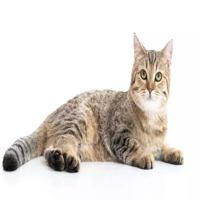

In [46]:
import requests
from PIL import Image
import torch.nn.functional as F

def predict_image(image_url, model):
    # --- ส่วนที่เพิ่มมา: ปลอมตัวเป็น Browser ---
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    try:
        # ใส่ headers เข้าไปในคำสั่ง get
        response = requests.get(image_url, stream=True, headers=headers, timeout=10)

        # เช็คว่าโหลดได้จริงไหม (200 แปลว่า OK)
        if response.status_code != 200:
            print(f"❌ เว็บไซต์ไม่อนุญาตให้โหลด (Status: {response.status_code})")
            return

        img = Image.open(response.raw).convert('RGB')
    except Exception as e:
        print(f"❌ เกิดข้อผิดพลาด: {e}")
        return

    # --- ส่วนเดิม ---
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_idx = torch.argmax(probabilities, dim=1).item()

    class_names = train_dataset.classes
    predicted_label = class_names[predicted_idx]
    confidence = probabilities[0][predicted_idx].item() * 100

    print(f"------------------------------------------------")
    print(f"🐶🐱 ผลการทาย: คือ '{predicted_label}'")
    print(f"📊 ความมั่นใจ: {confidence:.2f}%")
    print(f"------------------------------------------------")
    display(img.resize((200, 200)))

# ลองลิงค์เดิมของคุณอีกรอบ
test_url = "https://thonglorpet.com/_content_images/petdiary/S0424.jpg.webp?vs=20250804154958"
predict_image(test_url, model)